正在读取: ./CIFAR10DVS/dog/cifar10_dog_14.aedat4 | 模式: count


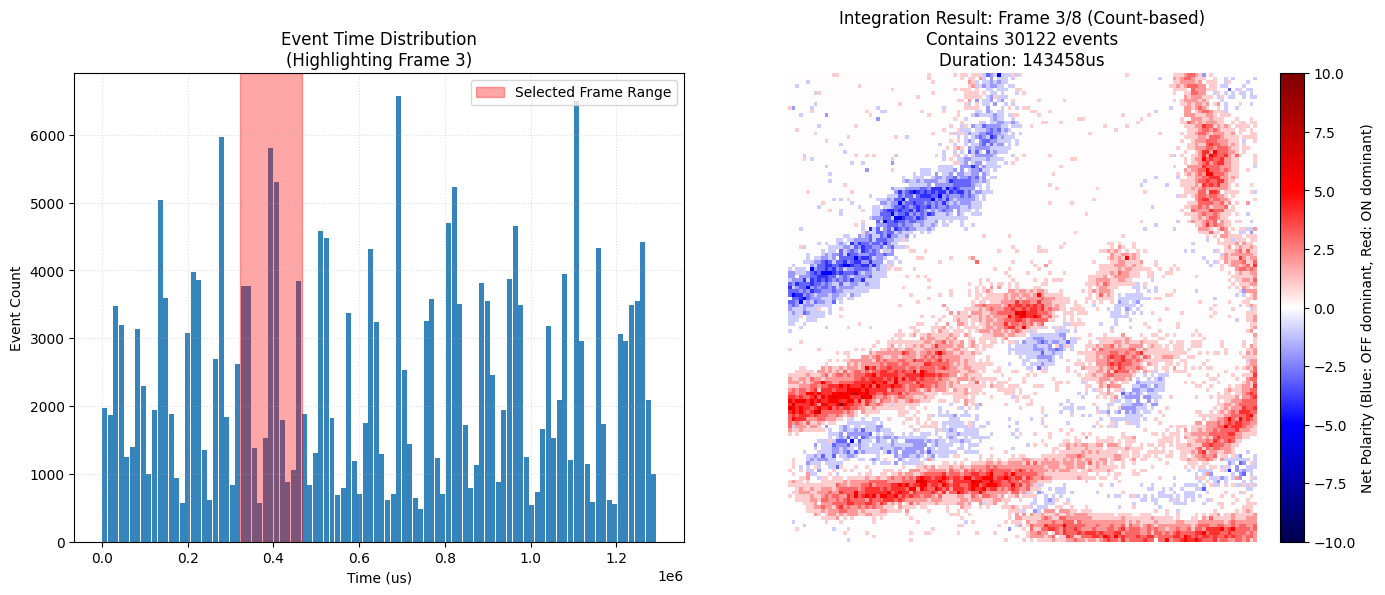

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 尝试导入 tonic
try:
    import tonic
except ImportError:
    tonic = None

def visualize_event_integration_final(file_path, frames_number=8, selected_frame_index=0, mode='count'):
    """
    file_path: 文件路径
    frames_number: 切分总帧数
    selected_frame_index: 选择展示第几帧 (0 到 frames_number-1)
    mode: 'count' (事件数均匀, 推荐) 或 'time' (时间均匀)
    """
    
    # -----------------------------------------------------------
    # 1. 读取数据
    # -----------------------------------------------------------
    if not os.path.exists(file_path):
        print(f"❌ 文件不存在: {file_path}")
        return

    print(f"正在读取: {file_path} | 模式: {mode}")
    
    if file_path.endswith('.aedat4'):
        if tonic is None: raise ImportError("需安装 tonic 和 aedat")
        events = tonic.io.read_aedat4(file_path)
        t, x, y, p = events['t'], events['x'], events['y'], events['p']
    elif file_path.endswith('.npz'):
        data = np.load(file_path)
        t, x, y, p = data['t'], data['x'], data['y'], data['p']
    else:
        print("不支持的文件格式")
        return

    # 确保时间从0开始，方便画图
    t = t - t[0]
    total_events = len(t)
    duration = t[-1]
    
    # -----------------------------------------------------------
    # 2. 计算切分逻辑 (获取选中帧的起止时间和事件索引)
    # -----------------------------------------------------------
    if mode == 'count':
        # --- 按事件数量均匀切分 ---
        events_per_frame = total_events // frames_number
        
        # 计算起止索引
        idx_start = selected_frame_index * events_per_frame
        if selected_frame_index == frames_number - 1:
            idx_end = total_events
        else:
            idx_end = (selected_frame_index + 1) * events_per_frame
            
        # 获取该帧对应的时间区间 (用于在直方图上画标记)
        frame_t_start = t[idx_start]
        frame_t_end = t[idx_end - 1]
        
        # 切片数据用于积分
        x_sel, y_sel, p_sel = x[idx_start:idx_end], y[idx_start:idx_end], p[idx_start:idx_end]
        
        info_str = f"Frame {selected_frame_index+1}/{frames_number} (Count-based)"
        sub_info = f"Contains {len(p_sel)} events\nDuration: {frame_t_end - frame_t_start:.0f}us"

    else:
        # --- 按时间均匀切分 ---
        dt = duration / frames_number
        frame_t_start = selected_frame_index * dt
        frame_t_end = (selected_frame_index + 1) * dt
        
        # 生成掩码
        mask = (t >= frame_t_start) & (t < frame_t_end)
        
        x_sel, y_sel, p_sel = x[mask], y[mask], p[mask]
        
        info_str = f"Frame {selected_frame_index+1}/{frames_number} (Time-based)"
        sub_info = f"Duration: {dt:.0f}us\nContains {len(p_sel)} events"

    # -----------------------------------------------------------
    # 3. 绘图
    # -----------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # === 左图：时间分布直方图 ===
    # 使用蓝色风格
    ax1.hist(t, bins=100, color='#1f77b4', alpha=0.9, rwidth=0.9)
    
    # 关键：在直方图上标记出选中帧的时间区间
    # 无论是 Time 模式还是 Count 模式，我们都算出了 frame_t_start 和 frame_t_end
    ax1.axvspan(frame_t_start, frame_t_end, color='red', alpha=0.35, label='Selected Frame Range')
    
    ax1.set_title(f"Event Time Distribution\n(Highlighting Frame {selected_frame_index+1})")
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Event Count")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle=':', alpha=0.4)

    # === 右图：积分结果 (蓝-白-红) ===
    img = np.zeros((128, 128), dtype=float)
    
    # 极性转换: ON(1)->1, OFF(0)->-1
    # 兼容 bool 类型或 int 类型的 p
    p_signed = np.where(p_sel > 0, 1, -1)
    
    np.add.at(img, (y_sel, x_sel), p_signed)
    
    # 确定色阶范围，保证 0 在中间 (白色)
    max_abs = max(abs(img.min()), abs(img.max()), 1)
    
    # 绘图
    im = ax2.imshow(img, cmap='seismic', vmin=-max_abs, vmax=max_abs, interpolation='nearest')
    
    ax2.set_title(f"Integration Result: {info_str}\n{sub_info}")
    ax2.axis('off') # 隐藏坐标轴刻度，更像图片
    
    # 添加 Colorbar
    cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label("Net Polarity (Blue: OFF dominant, Red: ON dominant)")

    plt.tight_layout()
    plt.show()

# =========================================================
# 🚀 运行测试
# =========================================================
# 请替换为你的文件路径
f_path = './CIFAR10DVS/dog/cifar10_dog_14.aedat4'

# 示例：将数据切分为 8 帧，查看第 3 帧 (Index=2)
# 模式：'count' (事件数固定)
visualize_event_integration_final(f_path, frames_number=8, selected_frame_index=2, mode='count')